In [1]:
import sys
sys.path.insert(1, '/afs/hep.wisc.edu/home/kkboone/software/StarWeights/StellarStreams')

import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
from scipy import interpolate as inter
from astropy.table import Table
import Config
import BalrogTestConfig as balrConfig

# Goal:

Produce a plot showing classification rates as a function of survey properties. For this, do some quality cuts, but don't do any color magnitude cuts. Maybe like stars as a function of skyvar uncertainty for the final plot.

In [2]:
detBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
matBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_matched_catalog_sof_run2_stars_v1.4.fits'

In [3]:
matStarData = fitsio.read(matBalrStarFile, columns = ['meas_ra', 'meas_dec', 'meas_EXTENDED_CLASS_SOF', 'bal_id'])

In [4]:
detStarData = fitsio.read(detBalrStarFile, columns = ['bal_id', 'flags_foreground', 'flags_badregions', 'flags_footprint', 'match_flag_1.5_asec'])

In [5]:
RA = matStarData['meas_ra']
DEC = matStarData['meas_dec']
# This is the class that the object was measured as.
CLASS = matStarData['meas_EXTENDED_CLASS_SOF']
# This is the ID from the measured catalog.
MAT_ID  = matStarData['bal_id']

In [6]:
sortInds = MAT_ID.argsort()
MAT_ID = MAT_ID[sortInds[::1]]
RA = RA[sortInds[::1]]
DEC = DEC[sortInds[::1]]
CLASS = CLASS[sortInds[::1]]

In [7]:
FOREGROUND = detStarData['flags_foreground']
BADREGIONS = detStarData['flags_badregions']
FOOTPRINT = detStarData['flags_footprint']
ARCSECONDS = detStarData['match_flag_1.5_asec']
FLAG_ID = detStarData['bal_id']

In [8]:
sortInds = FLAG_ID.argsort()
FLAG_ID = FLAG_ID[sortInds[::1]]
FOREGROUND = FOREGROUND[sortInds[::1]]
BADREGIONS = BADREGIONS[sortInds[::1]]
FOOTPRINT = FOOTPRINT[sortInds[::1]]
ARCSECONDS = ARCSECONDS[sortInds[::1]]

In [9]:
cropInds = np.isin(FLAG_ID, MAT_ID)
            
FOREGROUND = FOREGROUND[cropInds]
BADREGIONS = BADREGIONS[cropInds]
FOOTPRINT = FOOTPRINT[cropInds]
ARCSECONDS = ARCSECONDS[cropInds]

In [10]:
cutIndices = np.where((FOREGROUND == 0) & 
                        (BADREGIONS < 2) & 
                        (FOOTPRINT == 1) & 
                        (ARCSECONDS < 2) &
                        (CLASS >= 0))[0]

In [11]:
RA = RA[cutIndices]
DEC = DEC[cutIndices]
CLASS = CLASS[cutIndices]

In [12]:
corrClass = np.zeros(len(CLASS))
corrClass[np.where(CLASS <= 1)[0]] = 1

In [13]:
pix = hp.ang2pix(4096, RA, DEC, nest = True, lonlat = True)

In [14]:
origCondFiles = balrConfig.origCondFiles
stelFile = balrConfig.stelFile

validPix = np.full(12*(4096**2), True, dtype = bool)
    
for file in origCondFiles:
    condData = fitsio.read(file) # This reads in the data.
    condSigExt = np.full(12*(4096**2), -1.6375e+30) # Gives a default value.
    condSigExt[condData['PIXEL']] = condData['SIGNAL'] # Changes all valid pixels to their corresponding signals.
    validPix[np.where(condSigExt < -100)] = False # An invalid survey property marks this pixel as false.

stelDensExt = fitsio.read(stelFile)['I'].flatten() # Loads in the stellar density.
validPix[np.where(stelDensExt < -100)] = False # Any non valid pixel has its value changed to False.

validPix = np.where(validPix)[0]

In [15]:
validPixCrop = np.isin(pix, validPix)

In [16]:
pix = pix[validPixCrop]
corrClass = corrClass[validPixCrop]

In [17]:
aveAcc = np.sum(corrClass) / len(corrClass)

In [18]:
condPix = np.unique(pix)

In [19]:
condMaps = []

for file in origCondFiles:
    condData = fitsio.read(file) # This reads in the data.
    condSigExt = np.full(12*(4096**2), -1.6375e+30) # Gives a default value.
    condSigExt[condData['PIXEL']] = condData['SIGNAL'] # Changes all valid pixels to their corresponding signals.
    condMaps.append(condSigExt[condPix])
    
stelDensExt = fitsio.read(stelFile)['I'].flatten() # Loads in the stellar density.
condMaps.append(stelDensExt[condPix])

condMaps = np.array(condMaps) # Converts to an array

In [20]:
_, origCorPixCounts = np.unique(np.append(pix[np.where(corrClass == 1)[0]], condPix), return_counts = True)
origCorPixCounts = origCorPixCounts - 1

_, origAllPixCounts = np.unique(np.append(pix, condPix), return_counts = True)
origAllPixCounts = origAllPixCounts - 1

In [21]:
sortInds = []
for i in range(len(condMaps)):
    sortInds.append(condMaps[i].argsort())
sortInds = np.array(sortInds)

In [22]:
binNum = 10
cutOffPercent = 0.01

In [23]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((len(condPix) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

In [24]:
xBins = []

for i in range(len(condMaps)):
    cond_Map_Sort = condMaps[i][sortInds[i][::1]]
    condBins = []
    for j in range(binNum):
        condBins.append(cond_Map_Sort[binIndLims[j]:binIndLims[j+1]])
    indXBin = []

    for j in range(binNum):
        indXBin.append(np.sum(condBins[j]) / len(condBins[j]))

    xBins.append(np.array(indXBin))

xBins = np.array(xBins)

In [25]:
yBinsOrig = []
for i in range(len(condMaps)):
    corSort = origCorPixCounts[sortInds[i][::1]]
    allSort = origAllPixCounts[sortInds[i][::1]]
    
    corBins = []
    allBins = []
    for j in range(binNum):
        corBins.append(corSort[binIndLims[j]:binIndLims[j+1]])
        allBins.append(allSort[binIndLims[j]:binIndLims[j+1]])
        
    indYBinOrig = []

    for j in range(binNum):
        indYBinOrig.append(np.sum(corBins[j]) / (aveAcc * np.sum(allBins[j])))

    yBinsOrig.append(np.array(indYBinOrig))

yBinsOrig = np.array(yBinsOrig)

In [26]:
corPixCounts = np.copy(origCorPixCounts)

In [27]:
def mostSigInd(y):
    maxSquaredDiff = 0
    index = -1
    
    maxSingError = np.max(np.abs(y - 1))
    
    if maxSingError <= cutOffPercent:
        return index
    
    for i in range(len(y)):
        yi = y[i]
        
        diff = np.sum((yi - 1)**2)
        
        if diff > maxSquaredDiff:
            maxSquaredDiff = diff
            index = i
            
    return index

In [28]:
while(True):

    yBins = []
    for i in range(len(condMaps)):
        corSort = corPixCounts[sortInds[i][::1]]
        allSort = origAllPixCounts[sortInds[i][::1]]

        corBins = []
        allBins = []
        for j in range(binNum):
            corBins.append(corSort[binIndLims[j]:binIndLims[j+1]])
            allBins.append(allSort[binIndLims[j]:binIndLims[j+1]])

        indYBin = []

        for j in range(binNum):
            indYBin.append(np.sum(corBins[j]) / (aveAcc * np.sum(allBins[j])))

        yBins.append(np.array(indYBin))

    yBins = np.array(yBins)

    index = mostSigInd(yBins)
    if index == -1:
        break

    corrFunc = inter.interp1d(xBins[index], yBins[index], bounds_error = False, fill_value = (yBins[index][0], yBins[index][-1]))

    corPixCounts = corPixCounts / (corrFunc(condMaps[index]))

    corPixCounts = corPixCounts * aveAcc * np.sum(origAllPixCounts) / np.sum(corPixCounts)

In [29]:
matplotlib.style.use('des_dr1')

origErrors = []

for condInd in range(len(Config.conditions)):

    condValues = condMaps[condInd]
    
    yOrig = []
    
    origCorSort = origCorPixCounts[sortInds[condInd][::1]]
    allSort = origAllPixCounts[sortInds[condInd][::1]]

    origCorBins = []
    allBins = []
    for j in range(binNum):
        origCorBins.append(origCorSort[binIndLims[j]:binIndLims[j+1]])
        allBins.append(allSort[binIndLims[j]:binIndLims[j+1]])

    for j in range(binNum):
        yOrig.append(np.sum(origCorBins[j]) / (aveAcc * np.sum(allBins[j])))

    yOrig = np.array(yOrig)
    
    origErrors.append(np.sum((yOrig - 1)**2))

origErrors = np.array(origErrors)

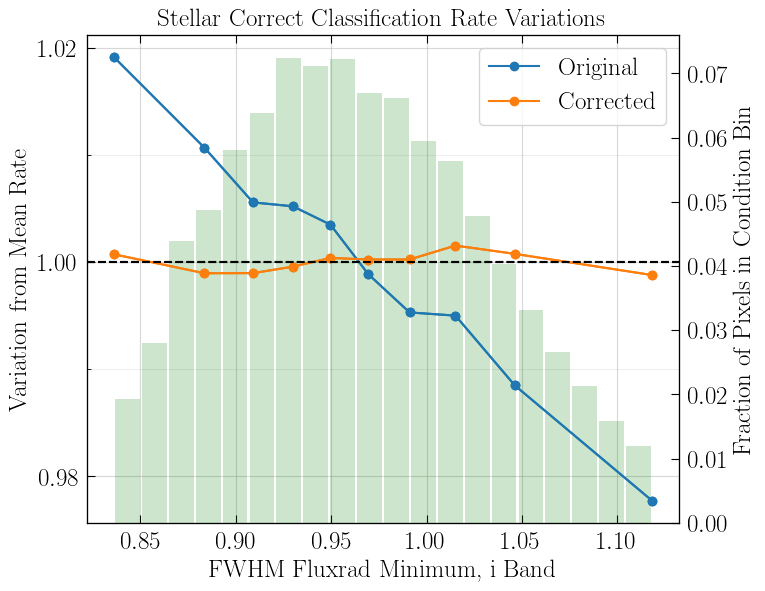

In [31]:
matplotlib.style.use('des_dr1')

condInd = np.where(origErrors == np.max(origErrors[np.where(origErrors != np.max(origErrors))[0]]))[0][0]

condition = Config.conditions[condInd]
condValues = condMaps[condInd]

x = xBins[condInd]

yOrig = []
yCorr = []

corSort = corPixCounts[sortInds[condInd][::1]]
origCorSort = origCorPixCounts[sortInds[condInd][::1]]
allSort = origAllPixCounts[sortInds[condInd][::1]]

corBins = []
origCorBins = []
allBins = []
for j in range(binNum):
    corBins.append(corSort[binIndLims[j]:binIndLims[j+1]])
    origCorBins.append(origCorSort[binIndLims[j]:binIndLims[j+1]])
    allBins.append(allSort[binIndLims[j]:binIndLims[j+1]])

for j in range(binNum):
    yCorr.append(np.sum(corBins[j]) / (aveAcc * np.sum(allBins[j])))
    yOrig.append(np.sum(origCorBins[j]) / (aveAcc * np.sum(allBins[j])))

yOrig = np.array(yOrig)
yCorr = np.array(yCorr)

fig, ax1 = plt.subplots()

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 2, 0.02)
minor_ticks = np.arange(0, 2, 0.01)

ax1.set_yticks(major_ticks)
ax1.set_yticks(minor_ticks, minor=True)

ax1.set_xlabel(condition)
ax1.tick_params(axis='y')
ax1.set_ylabel(r'Variation from Mean Rate')
ax1.plot(x, yOrig, label = 'Original', marker = 'o')
ax1.plot(x, yCorr, label = 'Corrected', marker = 'o')
ax1.axhline(y = 1, color = 'black', linestyle = '--')
# And a corresponding grid
ax1.grid(which='both')

# Or if you want different settings for the grids:
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)
# ax1.grid()
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.tick_params(axis='y')
ax2.set_ylabel('Fraction of Pixels in Condition Bin')
ax2.hist(condValues, bins = np.linspace(np.min(x), np.max(x), 21), color = 'green', rwidth = 0.923, alpha = 0.2, weights = np.ones(len(condValues)) / len(condValues))

ax3 = ax1.twinx()
ax3.tick_params(axis='y', right = False, labelright = False)
ax3.plot(x, yOrig, marker = 'o')
ax3.plot(x, yCorr, marker = 'o')
ax3.axhline(y = 1, color = 'black', linestyle = '--')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Stellar Correct Classification Rate Variations')
plt.savefig('Balrog Stellar Classification Plot')